# **Торговый Робот**

In [ ]:
#если установленны то не нужно
pip install yfinance
pip install mpl_finance

SyntaxError: ignored

In [356]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import urllib
stock = 'TSLA' # сток
date_start = '2019-12-21' #дата начала отсчета в формате 'ГГ-ММ-ДД'
date_end = '2021-12-21' #сегодняшняя дата в формате 'ГГ-ММ-ДД'
stop_loss = 30 # стоплос в процентах
money = 1000 # Количество денег
short_ma = 6 # количество дней для расчета малой скользящей средней
long_ma = 12 # количество дней для расчета большой скользящей средней

In [357]:
data = yf.download(stock,date_start, date_end)
stop_loss = 1 - stop_loss/100
data['MA_' + str(short_ma)] = data['Close'].rolling(short_ma).mean()
data['MA_' + str(long_ma)] = data['Close'].rolling(long_ma).mean()
signals = pd.DataFrame(index=data.index)
signals['signal'] = 0.0
signals['signal'][short_ma:] = np.where(data['MA_'+ str(short_ma)][short_ma:] > 
                                        data['MA_'+ str(long_ma)][short_ma:], 1.0, 0.0)
def fillBuy(colomn):
  arr = list(colomn)
  buf = 0
  leng = len(arr)
  for i in range(1,leng):
    if (arr[i] != 0 and arr[i] != -1):
      buf = arr[i]
    elif (arr[i] == 0 and buf != 0):
      arr[i] = buf
    elif (arr[i] == -1):
      arr[i] = buf
      buf = 0
    elif (buf == 0 and arr[i] == 0):
      arr[i] = 0
    i += 1
  return pd.Series(np.array(arr), signals.stop_loss.index)

def calcProfit(values, money, positions, sell, lim):
  val = list(values)
  mon = list(money)
  pos = list(positions)
  sel = list(sell)
  buf = 0
  leng = len(val)
  for i in range(1,leng):
    if(pos[i] == 1 and lim > 0):
      buf = lim // val[i]
      lim = lim - buf * val[i]
      mon[i] = lim
    if(sel[i] == 1 and buf):
      mon[i] = lim + buf * val[i]
      lim = mon[i]
      buf = 0
    else:
      mon[i] = lim
    i += 1
  return pd.Series(np.array(mon), signals.stop_loss.index)

def calcBuy(values, money, positions, sell, lim, buy):
  val = list(values)
  mon = list(money)
  pos = list(positions)
  sel = list(sell)
  buy_ = list(buy)
  buf = 0
  leng = len(val)
  for i in range(1,leng):
    if(pos[i] == 1 and lim > 0):
      buf = lim // val[i]
      lim = lim - buf * val[i]
      buy_[i] = buf * val[i]
      mon[i] = lim
    if(sel[i] == 1 and buf):
      mon[i] = lim + buf * val[i]
      lim = mon[i]
      buf = 0
    else:
      mon[i] = lim
    i += 1
  return pd.Series(np.array(buy_), signals.stop_loss.index)

def calcSale(values, money, positions, sell, lim, sale):
  val = list(values)
  mon = list(money)
  pos = list(positions)
  sel = list(sell)
  sale_ = list(sale)
  buf = 0
  leng = len(val)
  for i in range(1,leng):
    if(pos[i] == 1 and lim > 0):
      buf = lim // val[i]
      lim = lim - buf * val[i]
      mon[i] = lim
    if(sel[i] == 1 and buf):
      mon[i] = lim + buf * val[i]
      lim = mon[i]
      sale_[i] = buf * val[i]
      buf = 0
    else:
      mon[i] = lim
    i += 1
  return pd.Series(np.array(sale_), signals.stop_loss.index)

signals['Value'] = data['Open'] 
signals['positions'] = signals['signal'].diff().shift(1)
signals['positions'] = np.where(signals['positions'].shift(-1) == -1, -1, signals['positions'])
signals['positions'] = np.where(signals['positions'].shift(1) == -1, 0, signals['positions'])
signals['stop_loss'] = 0.0
signals['stop_loss'] = np.where(signals.positions ==1, signals.Value * stop_loss, 0)
signals['stop_loss'] = np.where(signals.positions == -1, -1, signals.stop_loss)
signals['stop_loss'] = fillBuy(signals['stop_loss'])
signals['stop_signal'] = 0
signals['stop_signal'] = np.where((signals.stop_loss > signals.Value) & (signals.positions != 1), 1, signals.stop_signal)
signals['stop_signal'] = np.where(signals.positions == -1, -1, signals.stop_signal)
signals['stop_signal'] = fillBuy(signals['stop_signal'])
signals['stop_signal'] = np.where(signals.positions == -1, 1, signals.stop_signal)
signals['sell'] = signals['stop_signal'].diff()
signals['sell'] = np.where(signals.sell == -1, 0, signals.sell)
signals['short_ma'] = data['MA_'+ str(short_ma)]
signals['long_ma'] = data['MA_'+ str(long_ma)]
signals['Buy'] = 0
signals['Sale'] = 0
signals['money'] = 0
signals['money'] = calcProfit(signals['Value'],signals.money,signals.positions,signals.sell, money)
signals['Buy'] = calcBuy(signals['Value'],signals.money,signals.positions,signals.sell, money, signals.Buy)
signals['Sale'] = calcSale(signals['Value'],signals.money,signals.positions,signals.sell, money, signals.Sale)
res = signals[['Buy', 'Sale']]
check_tabl = signals[['Buy', 'Sale', 'money']]
res

[*********************100%***********************]  1 of 1 completed


,Buy,Sale
Date,,
2019-12-23,0.0,0.0
2019-12-24,0.0,0.0
2019-12-26,0.0,0.0
2019-12-27,0.0,0.0
2019-12-30,0.0,0.0
...,...,...
2021-12-14,0.0,0.0
2021-12-15,0.0,0.0
2021-12-16,0.0,0.0


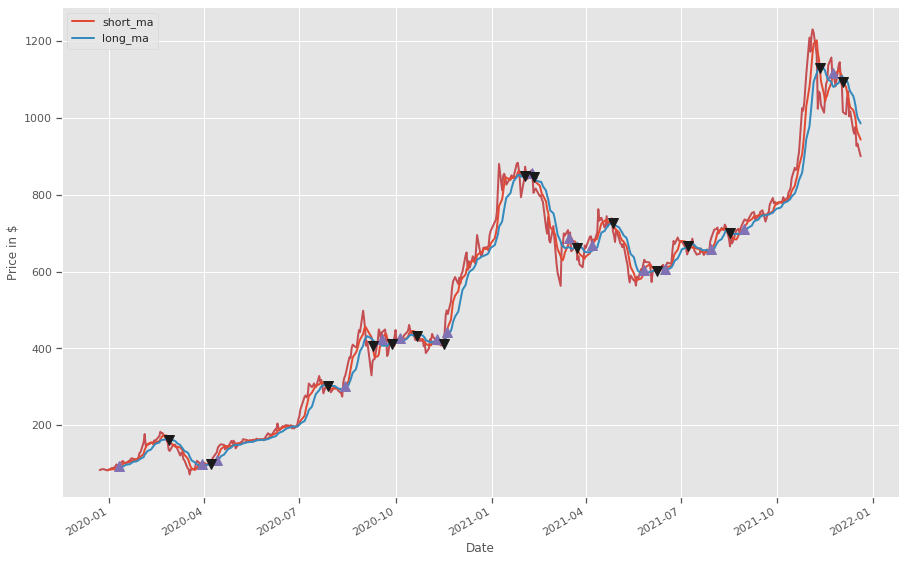

In [358]:
# Initialize the plot figure
fig = plt.figure(figsize=(15, 10))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
data['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_ma', 'long_ma']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_ma[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.sell == 1.0].index, 
         signals.short_ma[signals.sell == 1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()



[*********************100%***********************]  1 of 1 completed


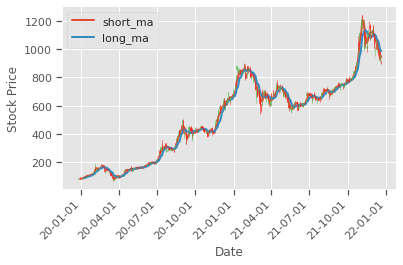

In [359]:

plt.style.use('ggplot')

# Extracting Data for plotting
df = yf.download(stock,date_start,date_end)
df = df.reset_index()

df.Date = pd.to_datetime(df.Date)

df = df[['Date', 'Open', 'High', 'Low', 'Close']]
df["Date"] = df["Date"].apply(mdates.date2num)

f1 = plt.subplot2grid((15, 10), (1,0 ), rowspan=30, colspan=30)
# наглядная на маленьких временных промежутках
signals[['short_ma', 'long_ma']].plot(ax=f1, lw=2.)
candlestick_ohlc(f1, df.values, width=.6, colorup='#53c156', colordown='#ff1717')
f1.xaxis_date()
f1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.show()


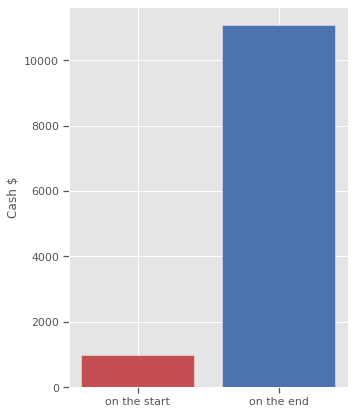

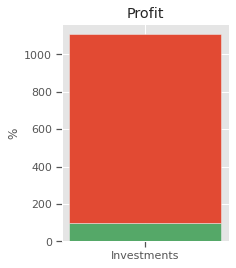

In [361]:
if (signals[signals.Sale != 0].values.size != 0):
  fig, ax = plt.subplots(figsize=(5, 7))
  len_s = signals[signals.sell == 1]['money'].size
  categories = ['on the start', 'on the end']
  arr_v = [money, list(signals[signals.sell == 1]['money'])[len_s - 1]]
  ax.set_ylabel('Cash $')
  ax.bar(categories, arr_v, color=['r','b']);

  fig, ax = plt.subplots(figsize=(3, 4))
  ax.set_title('Profit')
  len_s = signals[signals.sell == 1]['money'].size
  categories = ['money', 'profit']
  mon_per = money / money * 100
  prof_per =  (list(signals[signals.sell == 1]['money'])[len_s - 1] - money) / money * 100
  arr_v = [mon_per,prof_per]
  ax.set_ylabel('%')
  plt.bar('Investments', mon_per, color='g')
  plt.bar('Investments', prof_per,bottom=mon_per )

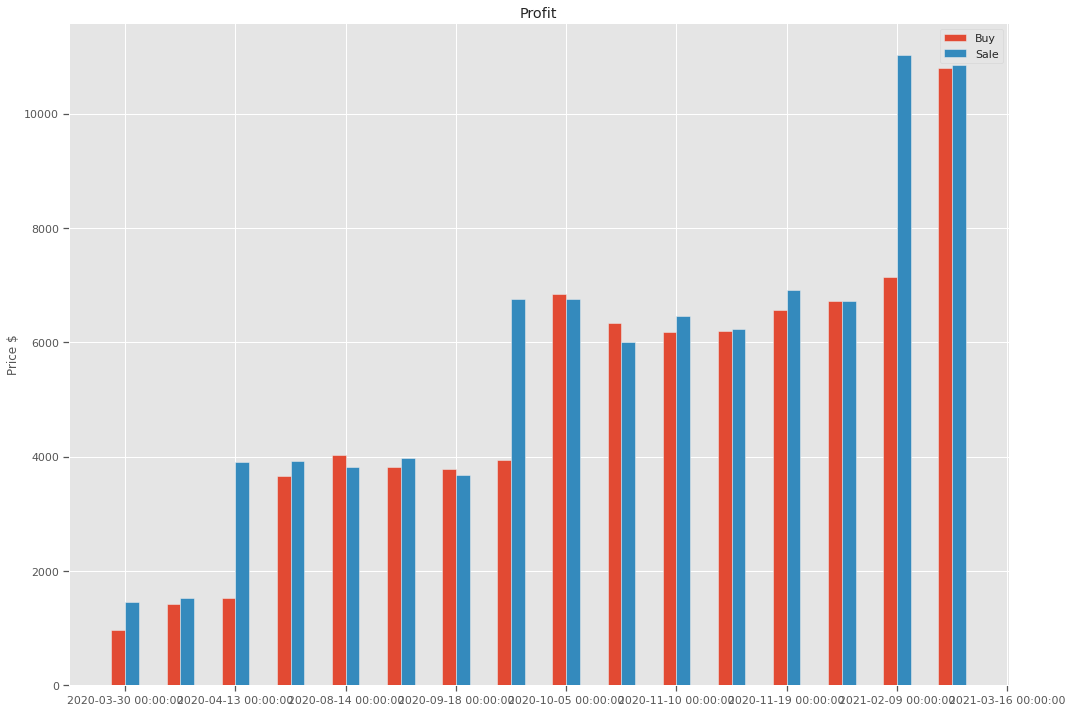

In [362]:

if (res[res['Buy'] != 0]['Buy'].size > res[res['Sale'] != 0]['Sale'].size):
  buy = list(res[res['Buy'] != 0]['Buy'].values)[:(res[res['Buy'] != 0]['Buy'].size - 1)]
  sale = list(res[res['Sale'] != 0]['Sale'].values)
  labels = list(res[res['Sale'] != 0]['Sale'].index)
elif(res[res['Buy'] != 0]['Buy'].size < res[res['Sale'] != 0]['Sale'].size):
  buy = list(res[res['Buy'] != 0]['Buy'].values)
  sale = list(res[res['Sale'] != 0]['Sale'].values[:(res[res['Sale'] != 0]['Sale'].size - 1)])
  labels = list(res[res['Buy'] != 0]['Buy'].index)
else:
  buy = list(res[res['Buy'] != 0]['Buy'].values)
  sale = list(res[res['Sale'] != 0]['Sale'].values)
  labels = list(res[res['Buy'] != 0]['Buy'].index)
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(x - width/2, buy, width, label='Buy')
rects2 = ax.bar(x + width/2, sale, width, label='Sale')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Price $')
ax.set_title('Profit')
# ax.set_xticks(x, labels)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [363]:
check_tabl

,Buy,Sale,money
Date,,,
2019-12-23,0.0,0.0,0.00000
2019-12-24,0.0,0.0,1000.00000
2019-12-26,0.0,0.0,1000.00000
2019-12-27,0.0,0.0,1000.00000
2019-12-30,0.0,0.0,1000.00000
...,...,...,...
2021-12-14,0.0,0.0,11075.71904
2021-12-15,0.0,0.0,11075.71904
2021-12-16,0.0,0.0,11075.71904
